# Workflows

Workflows in `hyrun` are represented usint the `JobGraph` class. A `JobGraph` instance comprises `hyrun` jobs and their (optional) dependencies in the form of a direct graph using the python package [`networkx`](https://networkx.org). This structure allows the construction and manipulation and analysis of complexed workflows using `hyrun`.

In [1]:
from hyrun.job import JobGraph, Job, get_workflow

## Construction 

A `JobGraph` is constructed from a list of jobs, that provide the hashes that will be the nodes (vertices) and a list of tuples of dependencies, that will be represented by the edges. `JobGraph` can either be created directly or via the wrapper `get_workflow()` which normalizes the input.

### Construction from `RunSettings`, `Job` and `dict`
A `hyrun.job.JobGraph` can be constructed using the wrapper `hyrun.job.get_workflow()` which takes as input a (list of) `hyrun.job.Job`, `hyset.v2.RunSettings`, `dict` or a combination of these. The wrapper will convert the latter two into a `hyrun.job.Job`. 

The following example generates a workflow with 3 jobs:

In [2]:
from hyrun.job import get_workflow
from hyset.v2 import RunSettings
job = Job(hash='from_job')
rs = RunSettings(logger={'print_level': 'critical'})
d = {'hash':'from_dict'}

workflow = get_workflow([job, rs, d])

In cases where more than one calculation should be processes within one job, e.g. for consecutive steps like model training and validation or remote parsing, `get_workflow()` expects nestes lists of `RunSettings`. The following workflow consiste of 3 jobs where the second job comprises two consecuctive calculations:

In [3]:
workflow = get_workflow([job, [rs, rs], d])

> **Note:**  
> The following workflow relations hold:
> - `get_work_flow(rs) == get_work_flow([[rs]])`
> - `get_work_flow([rs, rs, rs]) == get_work_flow([[rs], [rs], [rs]])`


### Construction with dependencies
Job dependencies are the graphs edges and defined as tuples `(ancestor, descendant)` where `descendant` depends on the `ancestor`. This means in practice that the `descendant` job is not going to be submitted until the `ancestor` job has the status `COMPLETED` (see below for node properties).

In [4]:
jobs = [Job(hash=f'hash{i}', status='UNKNOWN') for i in range(7)]
dependencies = [(jobs[i].hash, jobs[j].hash) for (i, j) in [(0, 1), (1, 2), (1, 3), (2, 4)]]

graph = JobGraph(nodes=jobs, edges=dependencies)
print(graph.nodes)
print(graph.edges)


['hash0', 'hash1', 'hash2', 'hash3', 'hash4', 'hash5', 'hash6']
[('hash0', 'hash1'), ('hash1', 'hash2'), ('hash1', 'hash3'), ('hash2', 'hash4')]


A `hyrun.graph.JobGraph` might also be created from jobs without hashes, the node labels are then the indices in which the nodes have been added to the graph.

In [5]:
newgraph = JobGraph(jobs=[Job() for _ in range(7)], dependencies=[(0, 1), (1, 2), (1, 3), (2, 4)])
print(newgraph)

╟── 0
╎   └─╼ 1
╎       ├─╼ 2
╎       │   └─╼ 4
╎       └─╼ 3
╟── 5
╙── 6


Nodes can be relabeled providing the respective mapping:

In [6]:
from copy import copy
newgraph = copy(graph)
newgraph.relabel_nodes({'hash0': 'water1', 'hash1': 'water2'})
print(newgraph)

╟── water1
╎   └─╼ water2
╎       ├─╼ hash2
╎       │   └─╼ hash4
╎       └─╼ hash3
╟── hash5
╙── hash6


## Loops and duplication

In general, loops are allowed:

In [7]:
newgraph = JobGraph(jobs=[Job() for _ in range(3)], dependencies=[(0, 1), (1, 2), (2, 0)])
for i in range(3):
    print(f'direct ancestor of node {i} are: {newgraph.direct_ancestors(i)}')


direct ancestor of node 0 are: [2]
direct ancestor of node 1 are: [0]
direct ancestor of node 2 are: [1]


Similar for self-loops:


In [8]:
newgraph = JobGraph(jobs=[Job() for _ in range(3)], dependencies=[(0, 1), (1, 2), (2, 0), (0, 0)])
print(newgraph.direct_ancestors(0))

[2, 0]


Node duplicates are overwritten:

In [9]:
newgraph = JobGraph(jobs=[Job(hash='hash0', status='UNKOWN'), Job(hash='hash1'), Job(hash='hash0', status='PENDING')])
print(newgraph.nodes)
print(newgraph['hash0'].get('status'))

['hash0', 'hash1']
PENDING


## Visualization

A simple overview of the graph with its depencies can be printed like this:

In [10]:
print(graph)

╟── hash0
╎   └─╼ hash1
╎       ├─╼ hash2
╎       │   └─╼ hash4
╎       └─╼ hash3
╟── hash5
╙── hash6



The order in which hyrun processes the jobs may differ from the order of the nodes the graph has been constructed with due to the dependencies.
The correct order in which the jobs run is therefore:

In [11]:
print(graph.topological)

['hash0', 'hash5', 'hash6', 'hash1', 'hash2', 'hash3', 'hash4']


and can be visualized:

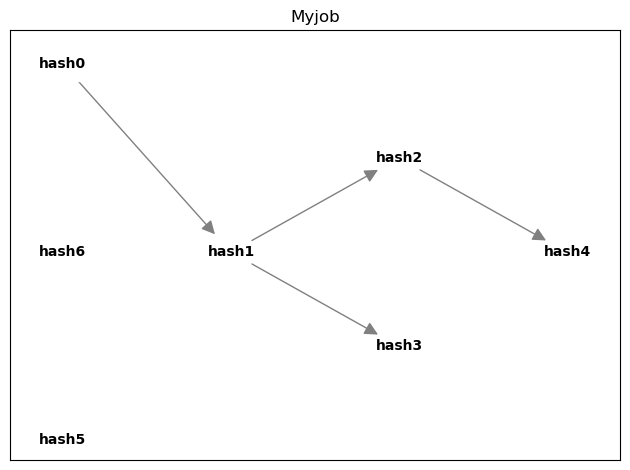

In [12]:
graph.show(title='Myjob')

## Node properties

Both nodes and edges can have properties. Per default, status and a db_id are extracted from the jobs.

In [13]:
graph['hash0']['status'] = 'RUNNING'
graph['hash1']['status'] = 'RUNNING'
graph['hash3']['status'] = 'FAILED'
graph['hash5']['status'] = 'PENDING'
graph['hash6']['status'] = 'COMPLETED'


for job in graph.nodes:
    if graph[job].get('status') != 'RUNNING':
        print(f'job {job} does *not* run')


job hash2 does *not* run
job hash3 does *not* run
job hash4 does *not* run
job hash5 does *not* run
job hash6 does *not* run


The properties can also be used for conveniently plotting the progress of a workflow:

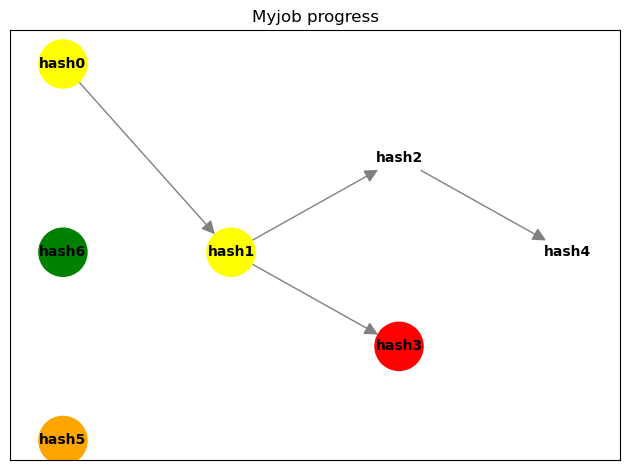

In [14]:
color_map = {'COMPLETED': 'green', 'RUNNING': 'yellow', 'PENDING': 'orange', 'FAILED': 'red', 'UNKNOWN': 'white'}
node_color = [color_map[graph[job].get('status', 'UNKNOWN')] for job in graph.nodes]
graph.show(title='Myjob progress', node_color=node_color, node_shape='o', node_size=1200)

## Edge properties

Edges can be equipped with json-serilizable objects: 

In [15]:
graph[('hash0', 'hash1')]['weight'] = 0.5
graph[('hash2', 'hash4')]['weight'] = 0.75

for u, v in graph.edges:
    if graph[(u, v)].get('weight', 0.0) > 0.2:
        print(f'edge {u} -> {v} has weight over 0.2')

edge hash0 -> hash1 has weight over 0.2
edge hash2 -> hash4 has weight over 0.2


For creating dynamical workflows, one can equip an edge with a script, i.e. a string representing a script or a path to a file.
This script will be executed before running the end-node associated with the edge.


In [16]:
graph[('hash0', 'hash1')]['script'] = '#!/usr/bin/python \nprint("Hello from edge hash0 -> hash1")'
print(graph[('hash0', 'hash1')].get('script'))

#!/usr/bin/python 
print("Hello from edge hash0 -> hash1")


## Run requirements

Properties can be used to define requirements for a job to run.
Per default, all nodes directly preceeding the given node must have the status `COMPLETED` (if a status is available):

In [17]:
graph['hash1']['status'] = 'COMPLETED'
assert graph.is_ready_to_run('hash2') # should return True
assert not graph.is_ready_to_run('hash4') # should return False, because hash2 is not completed yet

Workflows represented by `hyrun.JobGraph` support custom run requirements.
In the following example, a job will run if

- directly preceeding nodes have status `Completed`
- weight of the corresponding edge is larger than a 0.5

In [18]:
jobs = [Job(hash=f'hash{i}') for i in range(3)]
dependencies = [(jobs[i].hash, jobs[j].hash) for (i, j) in [(0, 1)]]
weights = [('hash0', 'hash1', 0.6)]
run_requirements = [{'element': 'node',
                   'property': 'status',
                   'operator': '==',
                   'value': 'COMPLETED'},
                   {'element': 'edge',
                   'property': 'weight',
                   'operator': '>=',
                   'value': 0.5}]

newgraph = JobGraph(nodes=jobs,
                    edges=dependencies,
                    weights=weights,
                    run_requirements=run_requirements)

newgraph['hash0']['status'] = 'COMPLETED'
newgraph['hash1']['status'] = 'PENDING'
assert not newgraph.is_ready_to_run('hash0') # should return False because this node already ran
assert newgraph.is_ready_to_run('hash1') # should return True because hash0 is completed and weight is 0.6 >= 0.5
newgraph[('hash0', 'hash1')]['weight'] = 0.4
assert not newgraph.is_ready_to_run('hash1') # should return False because weight is 0.4 < 0.5
assert newgraph.is_ready_to_run('hash2') # should return True because hash2 has no dependencies


This can be used to manually manipulate a workflow:


In [19]:
def script(prev=None, curr=None):
    print(f'Running script() for job {curr} with ancestor {prev}')

next_job = 'hash1'
assert not newgraph.is_ready_to_run(next_job)
previous_jobs = newgraph.direct_ancestors(next_job)
if all(newgraph[node]['status']  == 'COMPLETED' for node in previous_jobs):
    script(prev=previous_jobs, curr=next_job)
    for node in previous_jobs:
        newgraph[(node, 'hash1')]['weight'] = 1.0 
assert newgraph.is_ready_to_run(next_job)
    

Running script() for job hash1 with ancestor ['hash0']


> **Note:**  
>
> `JobGraph` *represents*, the jobs, i.e., if one ones to modify an *actual* job, one has to access it via the database, e.> g., via `JobGraph['node'].get('db_id')` or by looking up the hash in the database:
> ```python:
> job = db.search_one(hash=node, resolve=True)
> # ... do stuff ...
> db.update_one(entry=job, db_id=job.db_id)
> ```

## Manipulation

Both nodes and edges can be added and removed.

In [20]:
newgraph = JobGraph(jobs=[Job(hash=f'hash{100+i}') for i in range(4)])
print(newgraph)

╟── hash100
╟── hash101
╟── hash102
╙── hash103


In [21]:
newgraph.add_edge('hash101', 'hash102')
newgraph.remove_node('hash103')
print(newgraph)

╟── hash100
╙── hash101
    └─╼ hash102


Note that per default, removing an edge does not remove any nodes, and thus the graph topology is changed:

In [22]:
newgraph = copy(graph)

newgraph.remove_edge('hash1', 'hash2')
newgraph.remove_node('hash6')
newgraph.add_node(Job(hash='hash7'))
newgraph.add_edge('hash3', 'hash7')
print(newgraph)



╟── hash0
╎   └─╼ hash1
╎       └─╼ hash3
╎           └─╼ hash7
╟── hash2
╎   └─╼ hash4
╙── hash5


An entire branch can be removed by removing all descendants:

In [23]:
newgraph = copy(graph)
newgraph.remove_edge('hash1', 'hash2', remove_descendants=True)
print(newgraph)


╟── hash0
╎   └─╼ hash1
╎       └─╼ hash3
╟── hash5
╙── hash6


In [24]:
print(graph.descendants('hash0'))
print(graph.descendants('hash5'))
    

['hash3', 'hash4', 'hash2', 'hash1']
[]


In [25]:
print(graph.ancestors('hash3'))
print(graph.ancestors('hash5'))

['hash0', 'hash1']
[]


## Storage

A graph can be dumped to disk and read again. Per default the 'node-link' format is used in order to produce a json seralizable object:

In [26]:
filename='jobgraph'
graph.write(filename=filename)


In [27]:
from pathlib import Path
print(Path(filename).read_text())
Path(filename).unlink()

{
    "directed": true,
    "multigraph": false,
    "graph": {},
    "nodes": [
        {
            "job_id": null,
            "db_id": null,
            "job_script": null,
            "status": "RUNNING",
            "hash": "hash0",
            "metadata": {},
            "tasks": [],
            "outputs": [],
            "layer": 0,
            "id": "hash0"
        },
        {
            "job_id": null,
            "db_id": null,
            "job_script": null,
            "status": "COMPLETED",
            "hash": "hash1",
            "metadata": {},
            "tasks": [],
            "outputs": [],
            "layer": 1,
            "id": "hash1"
        },
        {
            "job_id": null,
            "db_id": null,
            "job_script": null,
            "status": "UNKNOWN",
            "hash": "hash2",
            "metadata": {},
            "tasks": [],
            "outputs": [],
            "layer": 2,
            "id": "hash2"
        },
        {
       

## Example

In this example, we perform a set of calculations and add the result to a json file. 
This is done via scripts which are performed after the calculator jobs.
In order for these to run, we create a dummy job.
In a real world-application, the dummy job would for example be the training of a machine learning model based on the collected results.


In [23]:
from hyrun.job import get_job, get_workflow

def get_molecules():
    """Generate a list of water molecules with slightly different coordinates."""
    from hyobj import Molecule
    import random
    import numpy as np
    from itertools import permutations
    from copy import deepcopy
    water = Molecule('O')
    xyz = np.array(water.coordinates)
    permutations = list(permutations([random.uniform(0, 0.1) for _ in range(4)], 3))
    waters =[]
    for p in permutations:
        mol = deepcopy(water)
        mol._coordinates[0] = xyz[0] + np.array(p)
        waters.append(mol)
    return waters

def get_run_settings(mol):
    """Return a RunSettings."""
    from hyset.v2 import convert_run_settings
    from hyif import Xtb
    return convert_run_settings(Xtb().setup(mol))

def gen_dummy_run_settings():
    """Generate a dummy job."""
    from hyset.v2 import convert_run_settings
    from hyif import Minimal
    return convert_run_settings(Minimal().setup(None, program='echo'))

def get_script(rs, summary_file=None):
    """Generate a script which parses the output of a run and updates a summary file."""
    from string import Template
    summary_file = 'summary.json' if summary_file is None else summary_file
    template =\
'''#!/Users/tilmann/anaconda3/bin/python

from hyif import Xtb
from dataclasses import dataclass

@dataclass
class Output:
    output_file: str
    output_folder: str

def parse_(Output):
    from hyif import Xtb
    return Xtb().parse(Output)

def update_summary_file(filename=None, new_data={}):
    from pathlib import Path
    import json
    if not Path(filename).exists():
        Path(filename).write_text('{}')

    with open(filename,'r+') as file:
            data = json.load(file)
            data.upadte(new_data)
            file.seek(0)
            json.dump(data, file, indent = 4)

if __name__ == '__main__':
    o = Output(output_file='$output_file', output_folder='$output_folder')
    d = parse_(o)
    update_summary_file(filename='$summary_file', new_data=d)
'''
    return Template(template).safe_substitute(
        output_file=rs.output_file.path,
        output_folder=rs.output_folder,
        summary_file=summary_file
    )



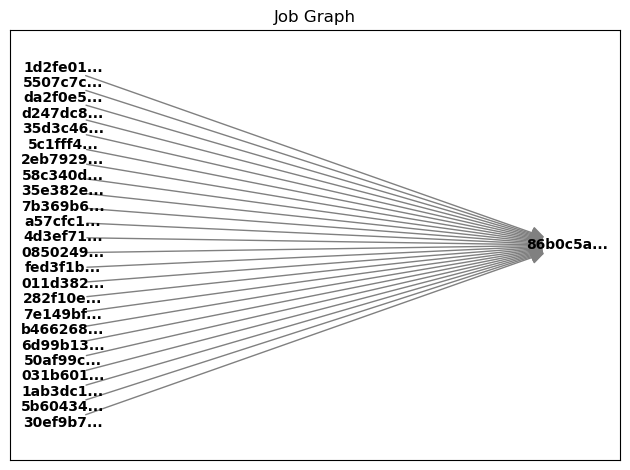

In [24]:
from hyrun.job import get_job, get_workflow

# generate calculator jobs
jobs = [get_job(get_run_settings(m)) for m in get_molecules()]
# generate dummy job, may also a job which acts on the results of the calculator jobs
dummy_job = get_job(gen_dummy_run_settings())
# create a workflow from the calculator jobs
wf = get_workflow(jobs)
# .. and add the dummy job
wf.add_node(dummy_job)
# create job dependencies and add the scripts to the edges
for i, job in enumerate(jobs):
    wf.add_edge(job.hash, dummy_job.hash, script=get_script(job.tasks[0]))
wf.show()



Check that the script is correctly parsed:

In [25]:
print(wf[(jobs[0].hash, dummy_job.hash)]['script'])

#!/Users/tilmann/anaconda3/bin/python

from hyif import Xtb
from dataclasses import dataclass

@dataclass
class Output:
    output_file: str
    output_folder: str

def parse_(Output):
    from hyif import Xtb
    return Xtb().parse(Output)

def update_summary_file(filename=None, new_data={}):
    from pathlib import Path
    import json
    if not Path(filename).exists():
        Path(filename).write_text('{}')

    with open(filename,'r+') as file:
            data = json.load(file)
            data.upadte(new_data)
            file.seek(0)
            json.dump(data, file, indent = 4)

if __name__ == '__main__':
    o = Output(output_file='48c924d6c18c9b112801d967233fe91c6485ae84e437991e3e3da9277425b215.out', output_folder='48c924d6c18c9b112801d967233fe91c6485ae84e437991e3e3da9277425b215')
    d = parse_(o)
    update_summary_file(filename='summary.json', new_data=d)



Check that all calculator jobs run but not the collector.

In [26]:
# check that the dummy job runs after all calculator jobs
for n in wf.nodes:
    if n == dummy_job.hash:
        print(f'Dummy {n}: {wf.is_ready_to_run(n)}')
    else:
        print(f'Calculator {n}: {wf.is_ready_to_run(n)}')


Calculator fed3f1bd2ed8326d6fff8b3d10b1e474c5400790e5dbcc3cb5c651226aad1815: True
Calculator 4d3ef71dea8c16d107da8fe2b9d343c892865ea47b02f81edc6ace3082af4f5d: True
Calculator 2eb79299f0a67d73232666ae814e4f27b123e3f265dda7676bd69b47efc51fd7: True
Calculator b4662689b79f0747508c14f6d71a4e71e89dce80405d9cbec72bec7b9854f282: True
Calculator 6d99b1326b359495626b5e4d1fb7c7d01ea44e1020a48cb0b3eb85f3c81b5828: True
Calculator da2f0e5a4950264dfbfa1d1dd075b1c593e89a09e1b300c425d0690bec879e06: True
Calculator 1ab3dc1ff6687f0691f6b9765c23d22d81c0af3f9cf1e3feafd13307d639816b: True
Calculator 35e382e5b62505ff266c8165a9b26c7e6fd28f35a927fd23fcf83cab96df7cbe: True
Calculator 7b369b6f1e54848e7fcdffc2a04986cd90d0c2c1c97186af3f820fc1b5b23050: True
Calculator 50af99c19d581743cfe37bd0a3ada868b4aee03efd43510abad2ee685561fec0: True
Calculator 1d2fe013dc20367c3d04a23851b3885e4036896bb589091c40cfb573e278f2f9: True
Calculator 031b6015d0510eed02a2523c69e71141a7f149a2615fb4f63b61fb4f2d0fb2d3: True
Calculator 011d3

Assume that one first wants to test that the calculator jobs actually run, one could use an arbitrary calculator job and let the others start only after this one is finished properly:

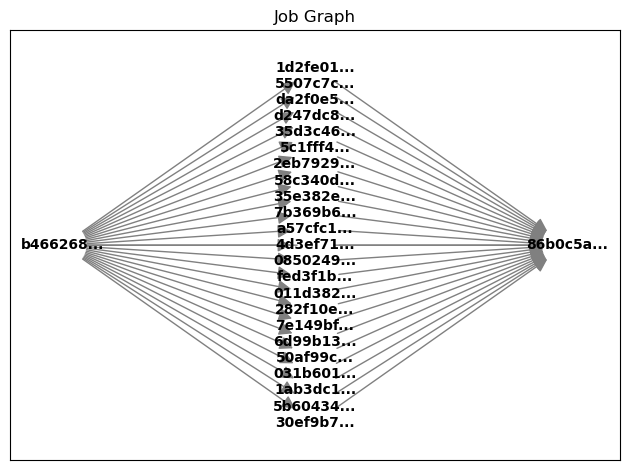

In [27]:
ref_job = 3
for i, job in enumerate(jobs):
    if i == ref_job:
        continue
    wf.add_edge(jobs[ref_job].hash, job.hash)
wf.show()

Re-check that only the singled-out calculator job is eligable to run:

In [28]:
# check that the dummy job runs after all calculator jobs
for n in wf.nodes:
    if n == dummy_job.hash:
        print(f'Dummy {n}: {wf.is_ready_to_run(n)}')
    else:
        print(f'Calculator {n}: {wf.is_ready_to_run(n)}')


Calculator fed3f1bd2ed8326d6fff8b3d10b1e474c5400790e5dbcc3cb5c651226aad1815: False
Calculator 4d3ef71dea8c16d107da8fe2b9d343c892865ea47b02f81edc6ace3082af4f5d: False
Calculator 2eb79299f0a67d73232666ae814e4f27b123e3f265dda7676bd69b47efc51fd7: False
Calculator b4662689b79f0747508c14f6d71a4e71e89dce80405d9cbec72bec7b9854f282: True
Calculator 6d99b1326b359495626b5e4d1fb7c7d01ea44e1020a48cb0b3eb85f3c81b5828: False
Calculator da2f0e5a4950264dfbfa1d1dd075b1c593e89a09e1b300c425d0690bec879e06: False
Calculator 1ab3dc1ff6687f0691f6b9765c23d22d81c0af3f9cf1e3feafd13307d639816b: False
Calculator 35e382e5b62505ff266c8165a9b26c7e6fd28f35a927fd23fcf83cab96df7cbe: False
Calculator 7b369b6f1e54848e7fcdffc2a04986cd90d0c2c1c97186af3f820fc1b5b23050: False
Calculator 50af99c19d581743cfe37bd0a3ada868b4aee03efd43510abad2ee685561fec0: False
Calculator 1d2fe013dc20367c3d04a23851b3885e4036896bb589091c40cfb573e278f2f9: False
Calculator 031b6015d0510eed02a2523c69e71141a7f149a2615fb4f63b61fb4f2d0fb2d3: False
Calcu